# MNE : Demo of multivariate statistics (decoding / MVPA)

Author : Alexandre Gramfort

In [1]:
# add plot inline in the page
%matplotlib inline
import matplotlib.pyplot as plt

First, load the mne package:

In [2]:
import mne

We set the log-level to 'WARNING' so the output is less verbose

In [3]:
mne.set_log_level('WARNING')

## Access raw data

Now we import the sample dataset. If you don't already have it, it will be downloaded automatically (but be patient approx. 2GB)

In [4]:
# raw_fname = '/Users/fraimondo/data/mne/sample_audvis_filt-0-40_raw.fif'
from mne.datasets import sample
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

Read data from file:

In [5]:
raw = mne.io.Raw(raw_fname, preload=True)
print raw

<RawFIF  |  n_channels x n_times : 376 x 41700>


High pass the data above 1Hz

In [6]:
raw.filter(1, None)

In [7]:
print raw.info

<Info | 20 non-empty fields
    bads : list | MEG 2443, EEG 053
    buffer_size_sec : numpy.float64 | 13.3196808772
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : dict | 3 items
    dig : list | 146 items
    events : list | 0 items
    file_id : dict | 4 items
    filename : str | /Users/fra.../sample_audvis_filt-0-40_raw.fif
    highpass : float | 1.0
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0
    meas_date : numpy.ndarray | 2002-12-03 16:01:10
    meas_id : dict | 4 items
    nchan : int | 376
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.153747559
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    hpi_subsyst

## Define and read epochs

First extract events:

In [8]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=True)

319 events found
Events id: [ 1  2  3  4  5 32]


Look at the design in a graphical way:

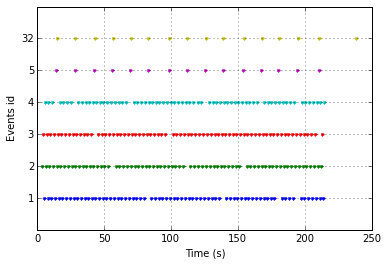

In [9]:
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp);

## From raw to epochs

Define epochs parameters:

In [10]:
event_id = dict(aud_l=1, aud_r=2)  # event trigger and conditions
tmin = -0.2  # start of each epoch
tmax = 0.4  # end of each epoch
baseline = None  # no baseline as data were high passed

reject = dict(eeg=150e-6, eog=150e-6)

picks = mne.pick_types(raw.info, eeg=True, meg=False,
                       eog=True, stim=False, exclude='bads')

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline,
                    reject=reject, preload=True)  # with preload
print epochs

<Epochs  |  n_events : 128 (all good), tmin : -0.2 (s), tmax : 0.4 (s), baseline : None,
 'aud_l': 63, 'aud_r': 65>


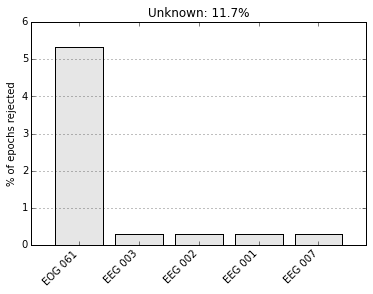

In [11]:
epochs.plot_drop_log();

Look at the ERF and contrast between left and rigth response

In [12]:
evoked_left = epochs['aud_l'].average()
evoked_right = epochs['aud_r'].average()
evoked_contrast = evoked_left - evoked_right

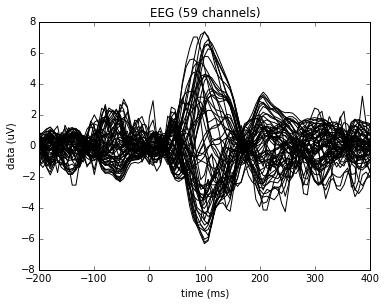

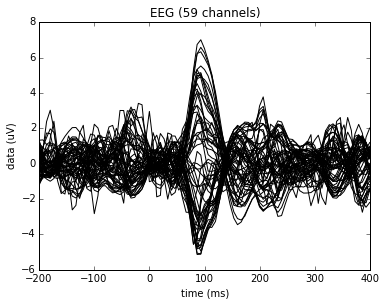

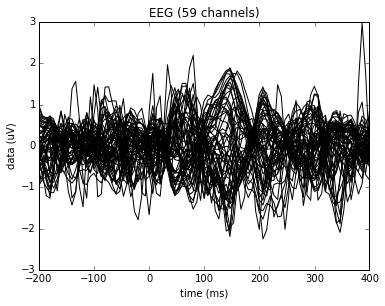

In [13]:
fig = evoked_left.plot()
fig = evoked_right.plot()
fig = evoked_contrast.plot()

Plot some topographies

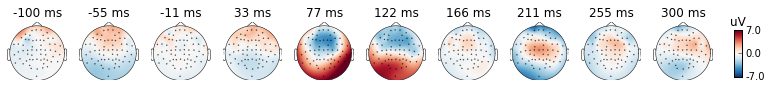

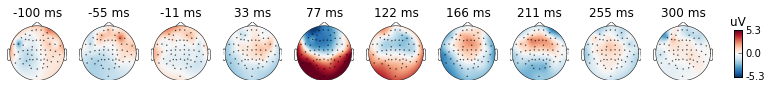

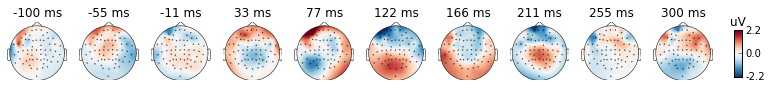

In [14]:
import numpy as np
times = np.linspace(-0.1, 0.3, 10)
fig = evoked_left.plot_topomap(times=times, ch_type='eeg', contours=0)
fig = evoked_right.plot_topomap(times=times, ch_type='eeg', contours=0)
fig = evoked_contrast.plot_topomap(times=times, ch_type='eeg', contours=0)

## Now let's see if we can classify single trials with an SVM

To have a chance at 50% accuracy equalize epoch count in each condition

In [15]:
epochs_list = [epochs[k] for k in event_id]
mne.epochs.equalize_epoch_counts(epochs_list)

A classifier takes as input an `x` and return `y` (0 or 1). Here x will be the data at one time point on all gradiometers (hence the term multivariate). We work with all sensors jointly and try to find a discriminative pattern between 2 conditions to predict the class.

In [16]:
n_times = len(epochs.times)

# Take only the data channels (here the gradiometers)
data_picks = mne.pick_types(epochs.info, meg=False, eeg=True, exclude='bads')

# Make arrays X and y such that :
# X is 3d with X.shape[0] is the total number of epochs to classify
# y is filled with integers coding for the class to predict
# We must have X.shape[0] equal to y.shape[0]

X = [e.get_data()[:, data_picks, :] for e in epochs_list]
y = [k * np.ones(len(this_X)) for k, this_X in enumerate(X)]
X = np.concatenate(X)
y = np.concatenate(y)

In [17]:
print X.shape, y.shape
print y

(126, 59, 91) (126,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


For classification we will use the scikit-learn package (http://scikit-learn.org/)

`
Reference:
Scikit-learn: Machine Learning in Python,
Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
`

In [18]:
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score, ShuffleSplit

# Define an SVM classifier (SVC) with a linear kernel
clf = SVC(C=1, kernel='linear')

Define a monte-carlo cross-validation generator (to reduce variance):

In [19]:
cv = ShuffleSplit(len(X), 10, test_size=0.2, random_state=42)

The goal is going to be to learn on 80% of the epochs and evaluate on the remaining 20% of trials if we can predict accurately.

In [20]:
X_2d = X.reshape(len(X), -1)
X_2d = X_2d / np.std(X_2d)
scores_full = cross_val_score(clf, X_2d, y, cv=cv, n_jobs=1)
print "Classification score: %s (std. %s)" % \
        (np.mean(scores_full), np.std(scores_full))

Classification score: 0.676923076923 (std. 0.0713355268884)


It's also possible to run the same decoder and each time point to know when in time the conditions can be better classified:

In [21]:
scores = np.empty(n_times)
std_scores = np.empty(n_times)

from scipy.stats import zscore

X = zscore(X, axis=-1)  # standardize features
for t, Xt in enumerate(X.T):  # Run cross-validation
    scores_t = cross_val_score(clf, Xt.T, y, cv=cv, n_jobs=1)
    scores[t] = scores_t.mean()
    std_scores[t] = scores_t.std()

A bit of rescaling

In [22]:
times = 1e3 * epochs.times # to have times in ms
scores *= 100  # make it percentage accuracy
std_scores *= 100

Now a bit of plotting

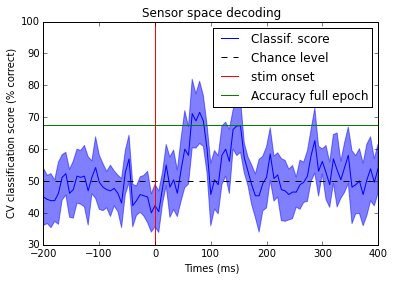

In [23]:
plt.plot(times, scores, label="Classif. score")
plt.axhline(50, color='k', linestyle='--', label="Chance level")
plt.axvline(0, color='r', label='stim onset')
plt.axhline(100 * np.mean(scores_full), color='g', label='Accuracy full epoch')
plt.legend()
hyp_limits = (scores - std_scores, scores + std_scores)
plt.fill_between(times, hyp_limits[0], y2=hyp_limits[1], color='b', alpha=0.5)
plt.xlabel('Times (ms)')
plt.ylabel('CV classification score (% correct)')
plt.ylim([30, 100])
plt.title('Sensor space decoding')

## Look at generalization over time

We can test how much the "decodability" stays over time.

Have a look at :

http://martinos.org/mne/dev/auto_examples/decoding/plot_decoding_time_generalization.html

to get an idea of what to expect.

In [24]:
from mne.decoding import GeneralizationAcrossTime

gat = GeneralizationAcrossTime(predict_mode='cross-validation', n_jobs=2)

# fit and score
gat.fit(epochs)
gat.score(epochs)

[[0.5078125,
  0.546875,
  0.5234375,
  0.546875,
  0.4765625,
  0.46875,
  0.453125,
  0.4453125,
  0.4140625,
  0.4375,
  0.4609375,
  0.4609375,
  0.4609375,
  0.4765625,
  0.484375,
  0.453125,
  0.46875,
  0.5234375,
  0.5234375,
  0.484375,
  0.4921875,
  0.4765625,
  0.4375,
  0.5078125,
  0.53125,
  0.53125,
  0.5,
  0.484375,
  0.453125,
  0.5234375,
  0.5390625,
  0.5078125,
  0.53125,
  0.4921875,
  0.5,
  0.4765625,
  0.484375,
  0.5234375,
  0.5703125,
  0.546875,
  0.421875,
  0.3671875,
  0.4140625,
  0.46875,
  0.5546875,
  0.5078125,
  0.5,
  0.546875,
  0.5390625,
  0.5703125,
  0.6015625,
  0.609375,
  0.6015625,
  0.5859375,
  0.5703125,
  0.5625,
  0.5,
  0.484375,
  0.4921875,
  0.46875,
  0.46875,
  0.4765625,
  0.53125,
  0.5625,
  0.4921875,
  0.5078125,
  0.46875,
  0.4609375,
  0.484375,
  0.5078125,
  0.5625,
  0.5,
  0.453125,
  0.453125,
  0.515625,
  0.4765625,
  0.5234375,
  0.5390625,
  0.5546875,
  0.5546875,
  0.53125,
  0.5078125,
  0.5703125,
  0.53

Now visualize

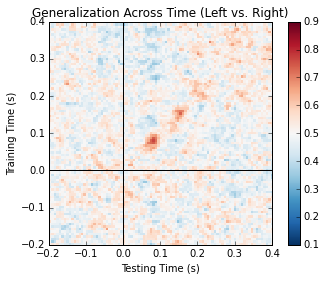

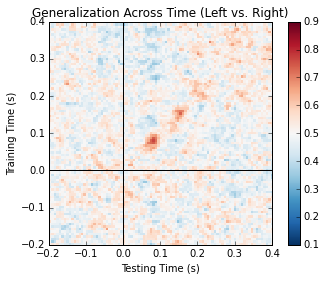

In [25]:
gat.plot(vmin=0.1, vmax=0.9,
         title="Generalization Across Time (Left vs. Right)")

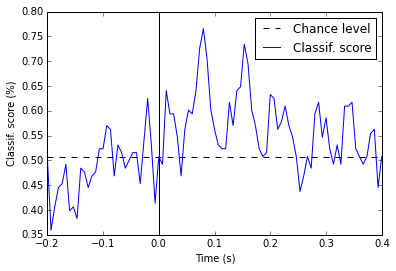

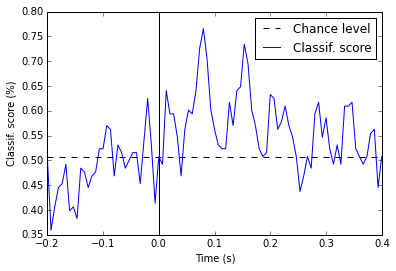

In [26]:
gat.plot_diagonal()  # plot decoding across time (correspond to GAT diagonal)

## Exercise

- Can you improve the performance using full epochs and a common spatial pattern (CSP) used by most BCI systems?

Have a look at the example

http://martinos.org/mne/dev/auto_examples/decoding/plot_decoding_csp_space.html